# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of Briefing: Exploring Factors Affecting Prices of Rooms on Airbnb

### Student ID: 18016662


### Word Count: 1443

# Reproducible Analysis

Please feel free to add as many code cells and markdown cells of comment/explanation as needed to make your code legible and clear. Your code should output any figures needed to disk.

In [ ]:
# Initialising the working environment
!conda create --name ucfnsz2 --file requirements.txt
!conda activate ucfnsz2

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Importing necessary libraries
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

## Loading Dataset

In [2]:
# Specifying the columns to be used in this assignment
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 
        'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'license', 
        'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month']

# Load the studied dataset
df = pd.read_csv('listings.csv',usecols=cols, low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

# Check the information about the attributes in the dataset
df.info()

Data frame is 67,903 x 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              67903 non-null  int64  
 1   listing_url                     67903 non-null  object 
 2   last_scraped                    67903 non-null  object 
 3   name                            67879 non-null  object 
 4   description                     65388 non-null  object 
 5   host_id                         67903 non-null  int64  
 6   host_name                       67871 non-null  object 
 7   host_since                      67871 non-null  object 
 8   host_location                   67722 non-null  object 
 9   host_about                      37543 non-null  object 
 10  host_response_rate              33615 non-null  object 
 11  host_acceptance_rate            33996 non-null  object 
 12  host_i

## Preparing dataset

In [3]:
# Dealing with NaNs and Nulls

# Then, let's chech how many null values contained in each column
# Note: I use proportions to represent the number of null values
print(df.isnull().sum(axis=0).sort_values(ascending=False)[:12]/len(df))

bathrooms                      1.000000
license                        1.000000
host_response_rate             0.504956
host_acceptance_rate           0.499345
host_about                     0.447108
review_scores_location         0.301430
review_scores_checkin          0.301415
review_scores_communication    0.300870
review_scores_cleanliness      0.300649
first_review                   0.280223
review_scores_rating           0.280223
last_review                    0.280223
dtype: float64


In [4]:
# From the printed information, 
# I found attributes of 'bathrooms' and 'license' are all null values
# So, they should be dropped from the dataset
df.drop(['bathrooms','license'],axis=1,inplace = True)

In [5]:
df.columns

Index(['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [6]:
# Transforming variables

# Boolean Values
df['host_is_superhost'] = df['host_is_superhost'].astype('bool')

# Dates
dates = ['last_scraped','host_since','first_review','last_review']
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d], infer_datetime_format=True)
    
# Categorical
cats = ['property_type','room_type']
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')

# Strings
print('Converting price')
df['price'] =  df.price.str.replace('$','').str.replace(',','').astype('float')

# Integers
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365','calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting last_scraped
Converting host_since
Converting first_review
Converting last_review
Converting property_type
Converting room_type
Converting price
Converting id
Converting host_id
Converting host_listings_count
	Converting to unsigned 16-bit integer.
Converting host_total_listings_count
	Converting to unsigned 16-bit integer.
Converting accommodates
Converting beds
	Converting to unsigned 16-bit integer.
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting calculated_host_listings_count


In [7]:
# Validation - Check the first five rows in the dataset
df.head()

id                         listing_url last_scraped  \
0  13913  https://www.airbnb.com/rooms/13913   2021-10-12   
1  15400  https://www.airbnb.com/rooms/15400   2021-10-12   
2  17402  https://www.airbnb.com/rooms/17402   2021-10-12   
3  17506  https://www.airbnb.com/rooms/17506   2021-10-12   
4  24328  https://www.airbnb.com/rooms/24328   2021-10-12   

                                                name  \
0                Holiday London DB Room Let-on going   
1                Bright Chelsea  Apartment. Chelsea!   
2              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3  Boutique Chelsea/Fulham Double bed 5-star ensuite   
4  Battersea bedroom & studio, parking, shared ga...   

                                         description  host_id  host_name  \
0  My bright double bedroom with a large window h...    54730      Alina   
1  Lots of windows and light.  St Luke's Gardens ...    60302   Philippa   
2  You'll have a wonderful stay in this superb mo...    67564        Liz   
3  Enjoy a chic stay in this elegant but fully mo...    67915  Charlotte   
4  Artist house, bright high ceiling rooms, priva...    41759        Joe   

  host_since                               host_location  \
0 2009-11-16             London, England, United Kingdom   
1 2009-12-05         Kensington, England, United Kingdom   
2 2010-01-04  Brighton and Hove, England, United Kingdom   
3 2010-01-05             London, England, United Kingdom   
4 2009-09-28     Greater London, England, United Kingdom   

                                          host_about  ... first_review  \
0  I am a Multi-Media Visual Artist and Creative ...  ...   2011-07-11   
1  English, grandmother,  I have travelled quite ...  ...   2012-07-16   
2  We are Liz and Jack.  We manage a number of ho...  ...   2011-09-18   
3  Named best B&B by The Times. Easy going hosts,...  ...          NaT   
4  I've been using Airbnb for a while now, both a...  ...   2011-11-01   

  last_review  review_scores_rating  review_scores_cleanliness  \
0  2011-09-13                  4.85                       4.84   
1  2019-08-10                  4.79                       4.88   
2  2019-11-02                  4.69                       4.68   
3         NaT                   NaN                        NaN   
4  2015-10-24                  4.89                       4.92   

   review_scores_checkin review_scores_communication  review_scores_location  \
0                   4.79                        4.89                    4.63   
1                   4.87                        4.82                    4.93   
2                   4.66                        4.66                    4.85   
3                    NaN                         NaN                     NaN   
4                   4.89                        4.93                    4.58   

   instant_bookable calculated_host_listings_count reviews_per_month  
0                 f                              2              0.17  
1                 f                              1              0.79  
2                 f                              2              0.35  
3                 f                              2               NaN  
4                 f                              1              0.77  

[5 rows x 40 columns]

In [8]:
# Saving the cleaned datasets
df.to_csv('listings_cleaned.csv',index=False)

## Statistics about the dataset

In [9]:
# Groupby Room_type to see the mainstream property_type of listings
df.groupby('room_type')['property_type'].value_counts()

room_type                                         
Entire home/apt  Entire rental unit                   26603
                 Entire residential home               5120
                 Entire condominium (condo)            3088
                 Entire serviced apartment             1098
                 Entire townhouse                       946
                                                      ...  
Shared room      Private room in bed and breakfast        0
                 Private room                             0
                 Lighthouse                               0
                 Hut                                      0
                 Yurt                                     0
Name: property_type, Length: 368, dtype: int64

In [126]:
# Groupby Room_type to see the mainstream property_type of listings
df['room_type'].value_counts()/len(df)

Entire home/apt    0.558841
Private room       0.428950
Shared room        0.006892
Hotel room         0.005316
Name: room_type, dtype: float64

In [10]:
# Finding maxima and minima
print(f'Maxima of the price is {df.price.max()}, and minima of that is {df.price.min()}')

Maxima of the price is 18012.0, and minima of that is 0.0


In [128]:
# Finding maxima and minima
print(f'Maxima of the price is {df.price.max()}, and minima of that is {df[df.price > 1].price.min()}')

Maxima of the price is 18012.0, and minima of that is 7.0


In [11]:
# The price of 0 could be room that are unavailable, so I will add another condition, price is higher than 0
df[df.price==df[df.price>1].price.min()][['price','id','listing_url','room_type','description']]

price        id                            listing_url     room_type  \
29452    7.0  23472846  https://www.airbnb.com/rooms/23472846   Shared room   
31543    7.0  25050392  https://www.airbnb.com/rooms/25050392  Private room   

                                             description  
29452  Light and airy house perfect place for a quick...  
31543  Small double room ideal for short stays during...

In [12]:
df[df.price==df.price.max()][['price','id','listing_url','room_type','description']]

price        id                            listing_url  \
26465  18012.0  21670579  https://www.airbnb.com/rooms/21670579   

             room_type                                        description  
26465  Entire home/apt  The moment you walk through the door you will ...

In [13]:
# Finding a range
dfr = df[ (df.price > df.price.quantile(q=0.25)) & (df.price < df.price.quantile(q=0.75)) ]
print(f"Rows: {dfr.shape[0]}")
print(f"Lower Quartile: {dfr.price.min():>6.2f}")
print(f"Upper Quartile: {dfr.price.max():>6.2f}")
dfr.head()

Rows: 33823
Lower Quartile:  46.00
Upper Quartile: 141.00


id                         listing_url last_scraped  \
0  13913  https://www.airbnb.com/rooms/13913   2021-10-12   
1  15400  https://www.airbnb.com/rooms/15400   2021-10-12   
6  33332  https://www.airbnb.com/rooms/33332   2021-10-13   
8  36660  https://www.airbnb.com/rooms/36660   2021-10-13   
9  38151  https://www.airbnb.com/rooms/38151   2021-10-13   

                                             name  \
0             Holiday London DB Room Let-on going   
1             Bright Chelsea  Apartment. Chelsea!   
6  Beautiful Ensuite Richmond-upon-Thames borough   
8                 You are GUARANTEED to love this   
9                             Double room/ lounge   

                                         description  host_id     host_name  \
0  My bright double bedroom with a large window h...    54730         Alina   
1  Lots of windows and light.  St Luke's Gardens ...    60302      Philippa   
6  Walking distance to Twickenham Stadium, 35 min...   144444       Chi-Chi   
8  <b>The space</b><br />This room is located on ...   157884  Agri & Roger   
9  <b>The space</b><br />Comfortable, large doubl...   163634          Lisa   

  host_since                        host_location  \
0 2009-11-16      London, England, United Kingdom   
1 2009-12-05  Kensington, England, United Kingdom   
6 2010-06-14   Isleworth, England, United Kingdom   
8 2010-07-04      London, England, United Kingdom   
9 2010-07-11                                   GB   

                                          host_about  ... first_review  \
0  I am a Multi-Media Visual Artist and Creative ...  ...   2011-07-11   
1  English, grandmother,  I have travelled quite ...  ...   2012-07-16   
6  Quite busy and often in a different place ever...  ...   2010-10-16   
8  We are a happy couple who live in a wonderful ...  ...   2012-05-02   
9                                                NaN  ...          NaT   

  last_review  review_scores_rating  review_scores_cleanliness  \
0  2011-09-13                  4.85                       4.84   
1  2019-08-10                  4.79                       4.88   
6  2011-01-23                  4.50                       4.71   
8  2021-09-24                  4.84                       4.84   
9         NaT                   NaN                        NaN   

   review_scores_checkin review_scores_communication  review_scores_location  \
0                   4.79                        4.89                    4.63   
1                   4.87                        4.82                    4.93   
6                   4.86                        5.00                    5.00   
8                   4.95                        4.96                    4.77   
9                    NaN                         NaN                     NaN   

   instant_bookable calculated_host_listings_count reviews_per_month  
0                 f                              2              0.17  
1                 f                              1              0.79  
6                 f                              1              0.06  
8                 t                              2              4.70  
9                 f                              1               NaN  

[5 rows x 40 columns]

In [14]:
# Deriving a New Variable
df['z'] = (df.price - df.price.mean()) / df.price.std()
df.z.describe()

count    6.790300e+04
mean    -3.075890e-15
std      1.000000e+00
min     -4.656574e-01
25%     -3.159648e-01
50%     -1.995372e-01
75%      6.705913e-03
max      5.945130e+01
Name: z, dtype: float64

<AxesSubplot:ylabel='Density'>

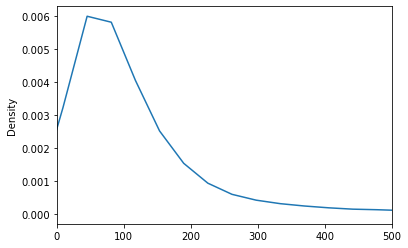

In [15]:
df.price.plot.kde(xlim=(0,500)) # histogram

Text(0.5, 1.0, 'Figure 1.2 The distribution of room prices that are greater than 80 percentile')

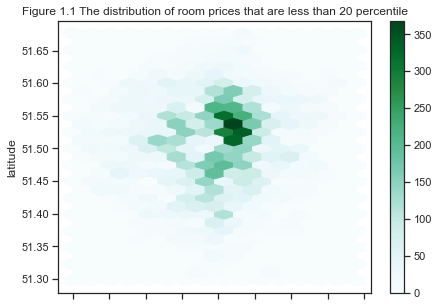

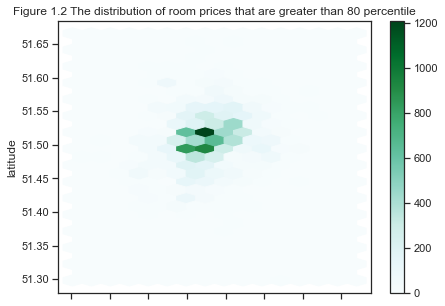

In [133]:
df[df.price < df.price.quantile(0.20)].plot.hexbin(x='longitude', y='latitude', gridsize=(15,15), figsize=(7,5))  #hex bin plot
plt.title('Figure 1.1 The distribution of room prices that are less than 20 percentile')
df[df.price > df.price.quantile(0.80)].plot.hexbin(x='longitude', y='latitude', gridsize=(15,15), figsize=(7,5))  #hex bin plot
plt.title('Figure 1.2 The distribution of room prices that are greater than 80 percentile')

## Spatial Analysis

In [18]:
# Read Geo-Data locally
ddir  = 'fsds-master/data/src/'

boros = gpd.read_file(ddir+'Boroughs.gpkg')
water = gpd.read_file(ddir+'Water.gpkg')
green = gpd.read_file(ddir+'Greenspace.gpkg')
london = gpd.read_file(ddir+'London.gpkg')

print('Done.')

Done.


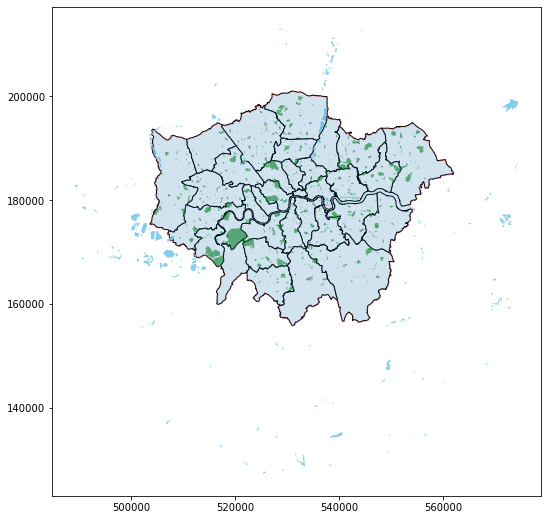

In [19]:
# Check the data
fig, ax = plt.subplots(1,1, figsize=(12,9))

boros.plot(edgecolor='black',facecolor='white',ax=ax)
water.plot(facecolor='skyblue',ax=ax)
green.plot(facecolor='green',alpha=0.6,ax=ax)
london.plot(edgecolor='red',alpha=0.2,ax=ax)

plt.show()

In [20]:
# Checking Lat/Long
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.50027, 51.295937
The top-right corner is 0.28857, 51.67998


<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
POINT (-0.16813 51.4878)


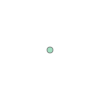

In [21]:
# Lat/Long to GeoSeries
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))

print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[1]) # Print out the object's contents
gdf.geometry.iloc[1] # The object knows how to print itself as a point

In [22]:
# Dealing with unsupported Dtypes
U16 = ['host_listings_count','host_total_listings_count','beds']
for u in U16:
    print(f'Converting {u}')
    gdf[u] = gdf[u].astype('float') # There are Na values

for c in cats:
    print(f"Converting {c}")
    gdf[c] = gdf[c].astype('str')
    
# Saving the GeoDF file
gdf.to_file('gdf_listings.gpkg',driver='GPKG')

Converting host_listings_count
Converting host_total_listings_count
Converting beds
Converting property_type
Converting room_type


In [23]:
print(water.geometry.crs)
print(water.total_bounds)

epsg:27700
[489068. 127350. 574437. 212920.]


epsg:27700
[504001.71363743 156900.30056738 558804.98845611 199730.8669564 ]


<AxesSubplot:>

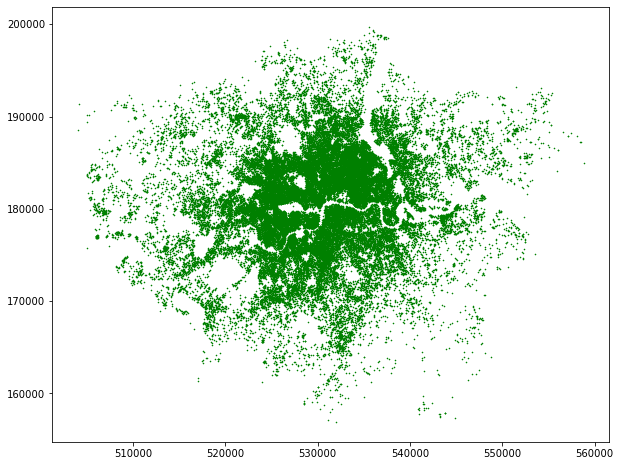

In [24]:
gdf = gdf.to_crs("epsg:27700")
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.5)

In [25]:
# Define a function plotting the spatial distribution of target variable
def plot_spatial_dist(gdf,column, title='London Airbnb Listings Price Per Night',legend_title='Price Per Night', save_fig='ppn.png'):
    
    # Read Geo-Data locally
    ddir  = 'fsds-master/data/src/'
    boros = gpd.read_file(ddir+'Boroughs.gpkg')
    water = gpd.read_file(ddir+'Water.gpkg')
    green = gpd.read_file(ddir+'Greenspace.gpkg')
    
    import mapclassify as mc
    import palettable.matplotlib as palmpl
    from legendgram import legendgram
    # Setting quantiles
    q = mc.Quantiles(gdf[column], k=5)
    

    # Plotting shapes
    f,ax = plt.subplots(figsize=(15,10))
    water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
    green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
    boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)
    
    # Plotting target variable
    gdf.plot(figsize=(15,12),column=column, scheme='Quantiles', k=5, 
             cmap='viridis', legend=True, marker='*', markersize=0.75, ax=ax)
    
    # Zoom in
    ax.set_xlim([500000,565000])
    ax.set_ylim([166000,196000])
    ax.axis('off') #don't plot the axes (bounding box)
    ax.set_title(title, fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
    a = ax.annotate('Source: InsideAirbnb (2021)',
                 xy=(0.905, 0.055), xycoords='figure fraction', 
                 horizontalalignment='right', verticalalignment='bottom', 
                 fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
    a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
    ax.get_legend().set_title(legend_title)  #set the legend title
    
    try:
        legendgram(f, ax, 
                   gdf.price, q.bins, bins=round(gdf.price.max()/10),
                   pal=palmpl.Viridis_5,
                   legend_size=(0.3, 0.1), 
                   loc='lower left',
                   clip=(0,750),
                   frameon=True
                  )
        f.savefig(save_fig, dpi=150)
    except:
        f.savefig(save_fig, dpi=150)
    
    

In [26]:
# Choropleth Mapping
print(f"The range of price is ${df.price.min():,.2f} to ${df.price.max():,.2f}")
print(f"The mean and median of the price are ${df.price.mean():,.2f} and ${df.price.median():,.2f}")

The range of price is $0.00 to $18,012.00
The mean and median of the price are $139.98 and $80.00


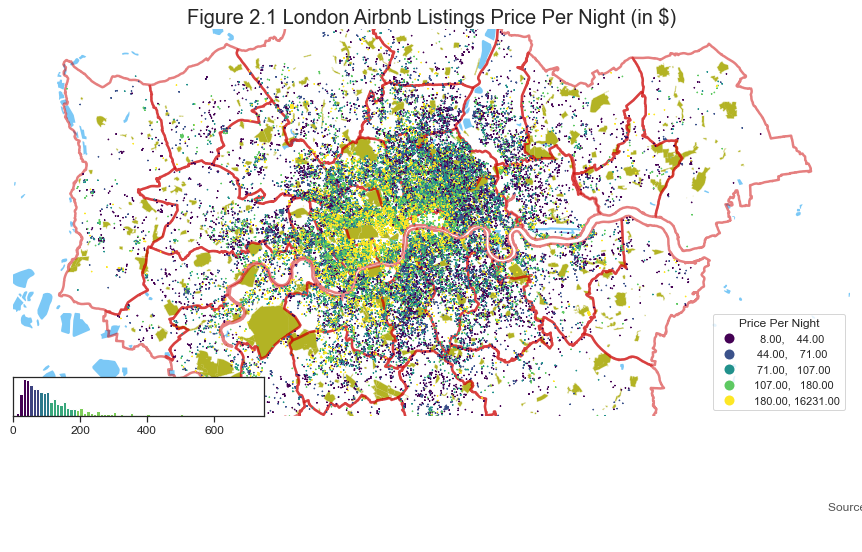

In [134]:
plot_spatial_dist(gdf,'price',title='Figure 2.1 London Airbnb Listings Price Per Night (in $)')

In [17]:
# Applying conditions to filtering listings I am interested of 

# Setting home/apts that are more expensive than $200 per night as pricey
# And that are cheaper than $50 per night as inexpensive
pricey = df[(df['room_type']=='Private room') & (df['price']>=100)]
print(f"Selected {pricey.shape[0]} rows of pricey listings for <Private room>")
inexpensive = df[(df['room_type']=='Private room') & (df['price']<= 30)]
print(f"Selected {inexpensive.shape[0]} rows of inexpensive listings for <Private room>")

Selected 3084 rows of pricey listings for <Private room>
Selected 6944 rows of inexpensive listings for <Private room>


In [28]:
# Get two studied groups
gdf_pricey = gdf[(gdf['room_type']=='Private room') & (gdf['price']>=100)]
gdf_inexpensive = gdf[(gdf['room_type']=='Private room') & (gdf['price']<= 30)]

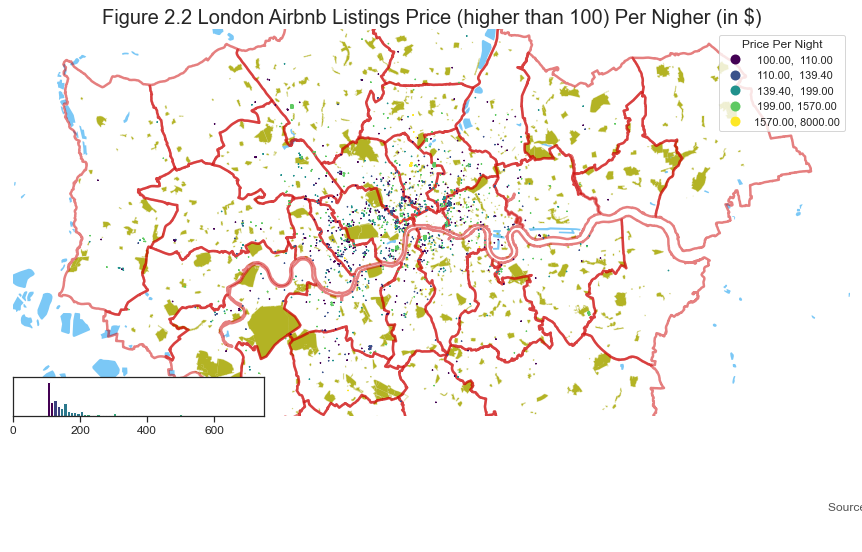

In [135]:
plot_spatial_dist(gdf_pricey,'price', title = 'Figure 2.2 London Airbnb Listings Price (higher than 100) Per Nigher (in $)')

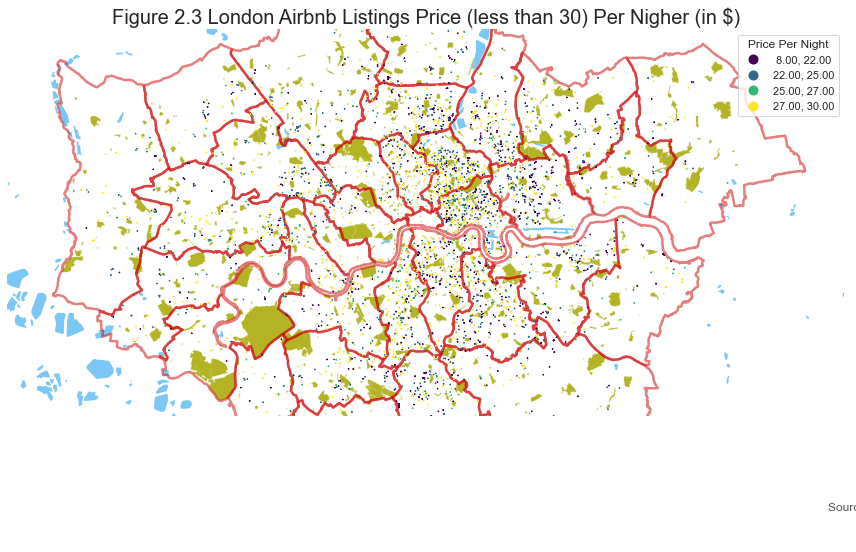

In [137]:
plot_spatial_dist(gdf_inexpensive,'price', title = 'Figure 2.3 London Airbnb Listings Price (less than 30) Per Nigher (in $)')

## Textual Data Analysis

In [31]:
import re
import string
import unicodedata
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [32]:
# Removing NA values in the TextFields
gdf.drop(index=(gdf[(gdf.description.isna()) | (gdf.amenities.isna()) | (gdf.host_about.isna())].index), inplace=True)

# Get two studied groups
gdf_pricey = gdf[(gdf['room_type']=='Private room') & (gdf['price']>=100)]
gdf_inexpensive = gdf[(gdf['room_type']=='Private room') & (gdf['price']<= 30)]

# Check some samples for textual data
strs = ['description','host_about','amenities']
gdf.loc[:5,strs]

description  \
0  My bright double bedroom with a large window h...   
1  Lots of windows and light.  St Luke's Gardens ...   
2  You'll have a wonderful stay in this superb mo...   
3  Enjoy a chic stay in this elegant but fully mo...   
4  Artist house, bright high ceiling rooms, priva...   
5  Big room with double bed/ clean sheets/ clean ...   

                                          host_about  \
0  I am a Multi-Media Visual Artist and Creative ...   
1  English, grandmother,  I have travelled quite ...   
2  We are Liz and Jack.  We manage a number of ho...   
3  Named best B&B by The Times. Easy going hosts,...   
4  I've been using Airbnb for a while now, both a...   
5  Easy going, friendly\n\nAttentive to detail an...   

                                           amenities  
0  ["Pack \u2019n play/Travel crib", "Smoke alarm...  
1  ["Air conditioning", "Heating", "Fire extingui...  
2  ["Smoke alarm", "Heating", "Dryer", "Dishes an...  
3  ["Hot water", "TV", "Air conditioning", "Smoke...  
4  ["Smoke alarm", "Heating", "Free parking on pr...  
5  ["Free street parking", "Wifi", "Kitchen", "Sm...

In [33]:
# Regular Expressions to explore the dataset

# Luxury Accommodation
gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)

# Assign it to a new data frame called lux
lux = gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].copy()

# Assign it to a new data frames in two different groups
lux_pricey = gdf_pricey[gdf_pricey.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].copy()
lux_inexpensive = gdf_inexpensive[gdf_inexpensive.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].copy()


In [34]:
# Proportions of luxury accomodations among all listings
lux['room_type'].value_counts()/len(lux)

Entire home/apt    0.774350
Private room       0.215945
Hotel room         0.007972
Shared room        0.001733
Name: room_type, dtype: float64

In [35]:
# Proportions of luxury accomodations among pricey private rooms
len(lux_pricey)/len(gdf_pricey)

0.08333333333333333

In [36]:
# Proportions of luxury accomodations among inexpensive private rooms
len(lux_inexpensive)/len(gdf_inexpensive)

0.02276319949415112

In [37]:
parks = gpd.read_file(ddir+'Greenspace.gpkg')

Text(0.5, 1.0, 'Figure 3.1 Price Distribution (per night in $) of Luxury Inexpensive rooms')

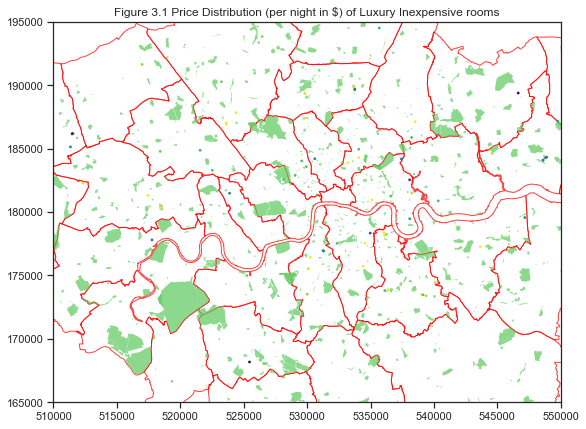

In [143]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
lux_inexpensive.plot(markersize=3, column='price', cmap='viridis', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);
plt.title("Figure 3.1 Price Distribution (per night in $) of Luxury Inexpensive rooms")

Text(0.5, 1.0, 'Figure 3.3 Price Distribution (per night in $) of Luxury Pricey rooms')

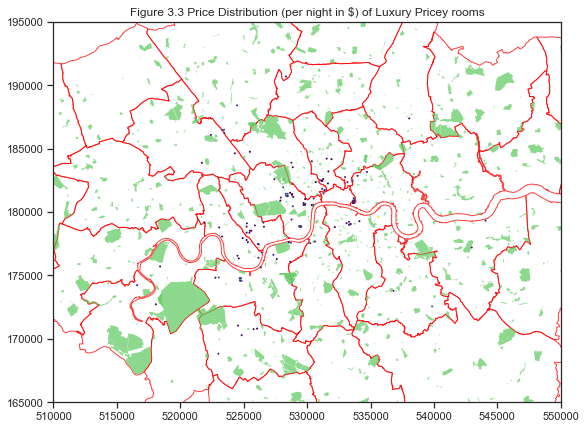

In [144]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
ax = lux_pricey.plot(markersize=1, column='price', cmap='viridis', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);
plt.title("Figure 3.3 Price Distribution (per night in $) of Luxury Pricey rooms")

In [40]:
# Regular Expressions to explore the dataset

# Comfortable Accommodation
# Assign it to a new data frame called lux
com = gdf[gdf.description.str.contains(r'comfor(?:t|table)', regex=True, flags=re.IGNORECASE)]

# Assign it to a new data frames in two different groups
com_pricey = gdf_pricey[gdf_pricey.description.str.contains(r'comfor(?:t|table)', regex=True, flags=re.IGNORECASE)].copy()
com_inexpensive = gdf_inexpensive[gdf_inexpensive.description.str.contains(r'comfor(?:t|table)', regex=True, flags=re.IGNORECASE)].copy()


In [41]:
# Proportions of luxury accomodations among all listings
com['room_type'].value_counts()/len(com)

Entire home/apt    0.660643
Private room       0.332108
Hotel room         0.003880
Shared room        0.003369
Name: room_type, dtype: float64

In [42]:
# Proportions of luxury accomodations among pricey private rooms
len(com_pricey)/len(gdf_pricey)

0.3619592875318066

In [43]:
# Proportions of luxury accomodations among inexpensive private rooms
len(com_inexpensive)/len(gdf_inexpensive)

0.18210559595320897

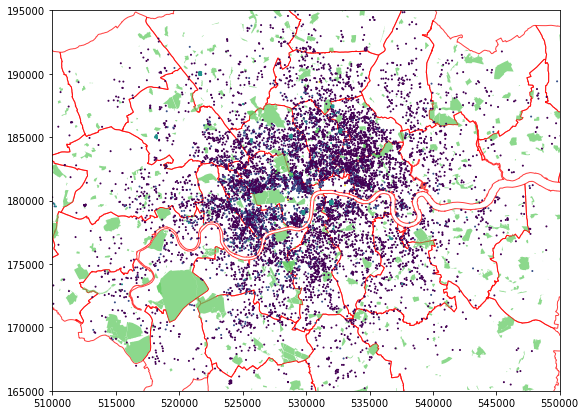

In [44]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
ax = com.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

Text(0.5, 1.0, 'Figure 3.2 Price Distribution (per night in $) of Comfortable Inexpensive rooms')

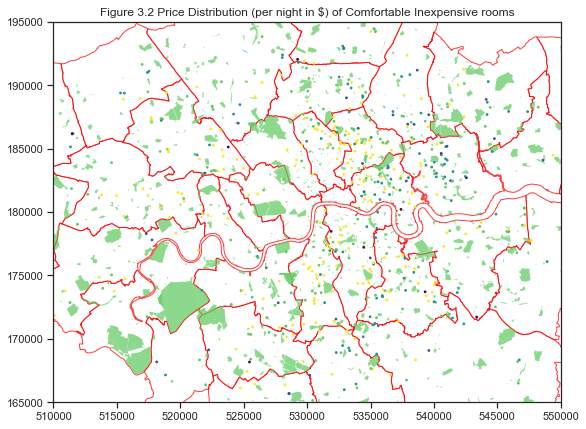

In [142]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
com_inexpensive.plot(markersize=3, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);
plt.title("Figure 3.2 Price Distribution (per night in $) of Comfortable Inexpensive rooms")

Text(0.5, 1.0, 'Figure 3.4 Price Distribution (per night in $) of Comfortable Priecy rooms')

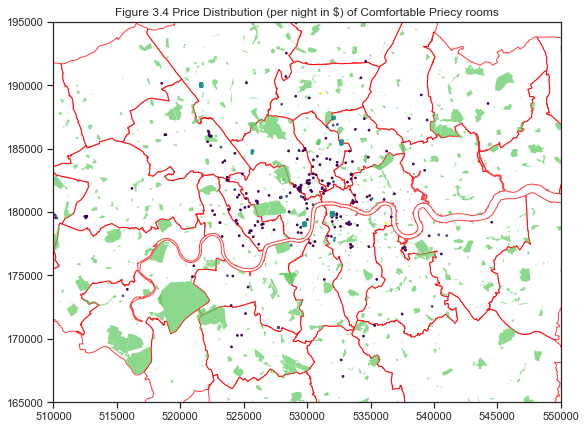

In [141]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
com_pricey.plot(markersize=3, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);
plt.title("Figure 3.4 Price Distribution (per night in $) of Comfortable Priecy rooms")

## Text Cleaning

In [48]:
# Define functions for basic filtering and preprocessing on textual data

# Lowering all cases
def lower_case(df):
    return [x.lower() for x in df if not re.match("^\s*$", x)]

# Removing HTML format
def remove_html(df):
    cleaned = []
    for l in df:
        tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l)
        soup = BeautifulSoup(tmp, "html.parser")
        if not re.match(r'^\s*$',soup.get_text()):
            cleaned.append(soup.get_text())
    return cleaned

# Removing punctuations                                        
def remove_punctuation(df):
    pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;]+')
    punkt   = []
    for c in df:
        punkt.append(re.sub(pattern, ' ', c))
    return punkt

# Removing stop words
def stop_words(df):
    from nltk.corpus import stopwords
    stopword_list = set(stopwords.words('english'))
    stopped = []
    for p in df:
        stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))
    return stopped

# Lemmatisation
def lemmatisation(df):
    from nltk.stem.wordnet import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for s in df:
        lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))
    return lemmas   

# Applying Normalisation / Combining all functions
def normalisation(df):
    result = lower_case(df)
    result = remove_html(result)
    result = remove_punctuation(result)
    result = stop_words(result)
    result = lemmatisation(result)
    return result


In [51]:
# # Using Combined Functions to preprocess textual data

# lux['description_norm'] = normalisation(lux['description'])
# aff['description_norm'] = normalisation(aff['description'])
# green['description_norm'] = normalisation(green['description'])

# Using existing package to preprocess textual data
from textual import *
# lux['description_norm'] = lux.description.apply(normalise_document)
com['description_norm'] = com.description.apply(normalise_document)

## Feature Extraction

In [52]:
corpus = com.description_norm.fillna(' ').values
print(corpus[0:2])

['bright double bedroom large window relaxed feeling comfortably fit one two centrally locate two block finsbury park enjoy great restaurant area easy access easy transport tube train bus baby child age welcome space hello everyone offer lovely double bedroom finsbury park area zone let shared apartment share apartment fully furnish self catering kitchen two people easily sleep well room queen size bed also travel cot baby guest small child require deposit front security gesture part give back return key trust anyone respond add would treat home care respect best wish alina gue'
 'typical victorian terrace london house colourfully decorate comfortable homely friendly quiet neighbourhood street plenty nearby restaurant takeaway great transport link right centre london westfield one europe large urban shopping mall doorstep get feel like local living london still easy access tourist area convenient airport eurostar space simply furnish low tech bedroom victorian terrace family home locat

In [53]:
# Frequency Dsitributions
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})
    
    
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

<FreqDist with 12414 samples and 818122 outcomes>
<FreqDist with 199535 samples and 818121 outcomes>
<FreqDist with 454966 samples and 818120 outcomes>
             Ngram Size 1
space               14687
room                14369
bedroom             12128
london              11095
bed                 10349
kitchen             10095
comfortable          9788
flat                 8461
apartment            8458
guest                7836
                 Ngram Size 2
living  room             3727
guest   access           3529
minute  walk             3124
double  bed              2755
central london           2688
fully   equip            1913
double  bedroom          1869
open    plan             1645
thing   note             1606
sofa    bed              1572
                               Ngram Size 3
king        size    bed                 907
fully       equip   kitchen             842
guest       access  guest               702
comfortable double  bed                 690
open        

In [54]:
# Count Vectoriser
vectorizer = CountVectorizer(ngram_range=(1,3))
vectorizer.fit(corpus)

# Find the vocabulary mapping
print(vectorizer.vocabulary_['stratford'])

tcorpus = vectorizer.transform(corpus)
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Counts"])
doc_df.sort_values('Counts', ascending=False).head(10)

558208


Counts
two                  3
easy                 2
finsbury             2
child                2
baby                 2
bedroom              2
double bedroom       2
park                 2
finsbury park        2
double               2

In [55]:
# TF/IDF Vectoriser
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.5, min_df=0.05)
tcorpus    = vectorizer.fit_transform(corpus)

doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

Weights
two             0.303106
easy            0.270917
double bedroom  0.252875
park            0.204560
give            0.175606
apartment       0.173659
part            0.172612
easy access     0.171578
travel          0.163806
area            0.162297

In [56]:
tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
tfidf.head()

access  access guest  accommodate  accommodation   airport      airy  \
0  0.079774           0.0          0.0            0.0  0.000000  0.000000   
1  0.146590           0.0          0.0            0.0  0.160484  0.000000   
2  0.066030           0.0          0.0            0.0  0.000000  0.000000   
3  0.075487           0.0          0.0            0.0  0.000000  0.146284   
4  0.070139           0.0          0.0            0.0  0.000000  0.000000   

       also  amenity  apartment  appliance  ...      west  whole  wifi  \
0  0.099746      0.0   0.173659        0.0  ...  0.000000    0.0   0.0   
1  0.000000      0.0   0.000000        0.0  ...  0.000000    0.0   0.0   
2  0.000000      0.0   0.000000        0.0  ...  0.000000    0.0   0.0   
3  0.000000      0.0   0.000000        0.0  ...  0.146744    0.0   0.0   
4  0.000000      0.0   0.000000        0.0  ...  0.000000    0.0   0.0   

     window    within  wooden  work     would  yol      zone  
0  0.127889  0.000000     0.0   0.0  0.159170  0.0  0.154325  
1  0.000000  0.000000     0.0   0.0  0.000000  0.0  0.000000  
2  0.000000  0.109767     0.0   0.0  0.131747  0.0  0.000000  
3  0.000000  0.000000     0.0   0.0  0.000000  0.0  0.000000  
4  0.000000  0.116597     0.0   0.0  0.139944  0.0  0.000000  

[5 rows x 339 columns]

In [145]:
# Decide to use TF/IDF Vectoriser for later analysis,
# since it will assign different weights to the same word based on according context.
# It should perform better when dealing with these short doc

# Organising the useful codes as one function
def tf_idf_process(corpus):
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(2,3), max_df=0.5, min_df=0.05)
    tcorpus    = vectorizer.fit_transform(corpus)
    print('Samples:')
    doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
    print(doc_df.sort_values('Weights', ascending=False).head(10))
    print('--------')
    
    return pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())

In [146]:
# Loop for two different groups
corpus_pricey = com.loc[com_pricey.index].description_norm.fillna(' ').values
print(corpus_pricey[0:2])
tfidf_pricey = tf_idf_process(corpus_pricey)

corpus_inexpensive = com.loc[com_inexpensive.index].description_norm.fillna(' ').values
print(corpus_inexpensive[0:2])
tfidf_inexpensive = tf_idf_process(corpus_inexpensive)

['please read house rule carefully ahead booking host guest help night long stay even night guest book room exceptions many thanks understand space please read house rule carefully ahead booking host guest exception many thanks understanding free wifi fresh white bed linen towel bath mat deposit clean fee stylish comfortable little room next underground station colourful fashionable notting hill buzzing portobello road locate within minute amenity central london minute pancras international eurostar station multiple connection direct transfer london airport'
 'one gorgeous light filled double bedroom sleeps share bathroom bath shower beautiful cottage near twickenham green min walk twickenham stadium last minute booking possible bespoke package arrange host andy usually residence absence arrange would free small single bed sleep one space beautiful light filled double bedroom gorgeous cottage leafy london suburb twickenham cottage well equip give comfortable stay necessary amenity twic

In [147]:
tfidf.sum().sort_values(ascending=False)[:10]

apartment    666.963117
flat         651.948432
access       508.895039
home         508.852921
double       492.969572
walk         489.793922
minute       484.658727
house        470.567374
large        461.348382
area         458.980470
dtype: float64

In [148]:
tfidf_pricey.sum().sort_values(ascending=False)[:10]

guest access        50.972804
minute walk         42.313951
central london      36.297682
living room         28.421716
double bed          28.224120
thing note          26.984979
room comfortable    23.006950
private bathroom    21.097828
shower room         20.600184
double bedroom      20.575924
dtype: float64

In [149]:
tfidf_inexpensive.sum().sort_values(ascending=False)[:10]

central london      60.646384
minute walk         51.971936
thing note          49.808392
double room         44.941780
double bed          44.133347
living room         42.054637
min walk            36.166572
double bedroom      31.993094
kitchen bathroom    30.715823
tube station        28.311326
dtype: float64

## Word Clouds

In [154]:
# Define a function plotting word clouds, the input is obtained word frequencies
def word_cloud(freq,title='Word Cloud'):
    plt.figure(figsize=(12, 12))
    Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(freq.sum())
    plt.imshow(Cloud) 
    plt.axis("off");
    plt.title(title)

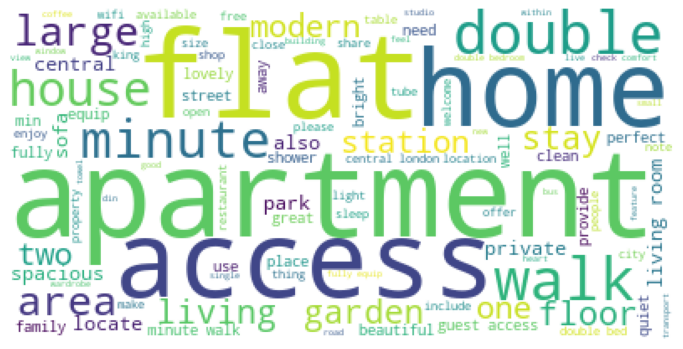

In [151]:
word_cloud(tfidf)

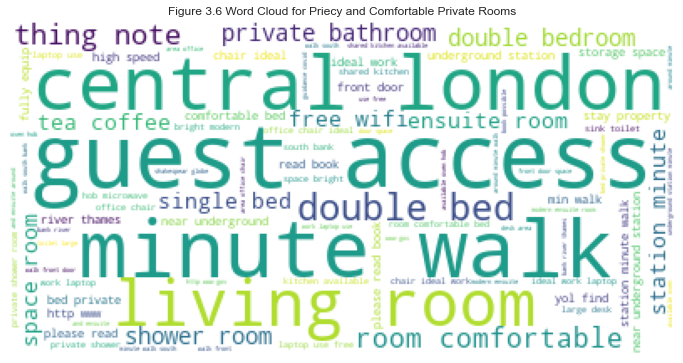

In [156]:
word_cloud(tfidf_pricey,title='Figure 3.6 Word Cloud for Priecy and Comfortable Private Rooms')

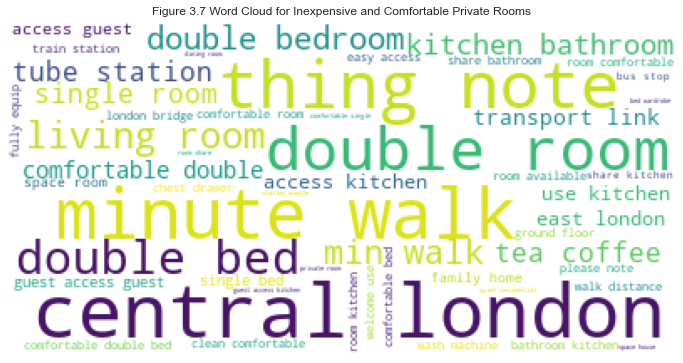

In [157]:
word_cloud(tfidf_inexpensive,title='Figure 3.7 Word Cloud for Inexpensive and Comfortable Private Rooms')

In [135]:
# Define a function for LDA Analysis
def LDA(corpus,ngram_range=(2,2)):
    vectorizer = CountVectorizer(ngram_range=ngram_range) # Notice change to ngram range (try 1,1 and 1,2 for other options)
    vectorizer.fit(corpus)
    tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

    LDA = LatentDirichletAllocation(n_components=10, random_state=42) # Might want to experiment with n_components too
    LDA.fit(tcorpus)
    
    # Get the first topic and according words with top frequencies
    first_topic = LDA.components_[0]
    top_words = first_topic.argsort()[-25:]
    
    # Print Feature names
    for i in top_words:
        print(vectorizer.get_feature_names()[i])

In [136]:
LDA(corpus)

equip kitchen
living area
london space
minute away
shower room
din area
first floor
bedroom apartment
walk distance
thing note
min walk
size bed
fully equip
sofa bed
double room
king size
ground floor
double bed
open plan
transport link
minute walk
double bedroom
living room
guest access
central london


In [137]:
LDA(corpus_pricey)

work area
sleep two
shop pub
fee please
check justpark
extra fee
accommodation extra
app space
please check
justpark app
parking available
underground station
desk comfortable
local shop
two double
recently refurbish
ensuite room
thing note
minute walk
check 00h
west end
high speed
double bed
private bathroom
guest access


In [138]:
LDA(corpus_inexpensive)

free parking
make sure
tea coffee
transport link
comfortable house
space room
london min
bar restaurant
cosy comfortable
public transport
double bed
comfortable double
double room
min bus
access kitchen
room toilet
family home
double bedroom
access guest
minute walk
shower room
min walk
thing note
central london
guest access


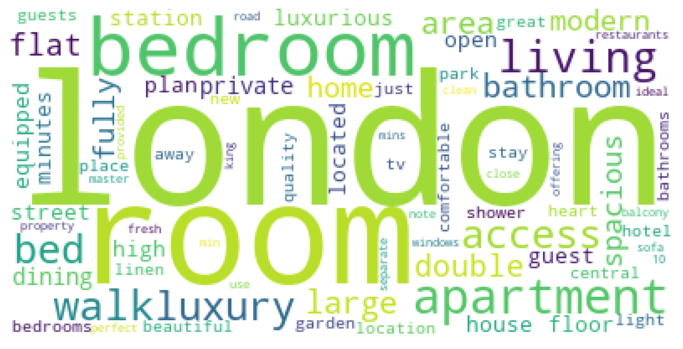

In [68]:
tdf = com # Saves having to change the variable name below

topic_values = LDA.transform(tcorpus)
topic_values.shape

pd.options.display.max_colwidth=20
tdf['Topic'] = topic_values.argmax(axis=1)
tdf.head()

vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(tdf[tdf.Topic==1].description.values) # tcorpus for transformed corpus

topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names())

plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

# Visualisation and Linked Data

<AxesSubplot:>

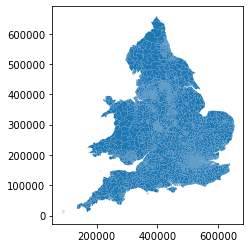

In [62]:
# Grab E+W MSOA Shapefile
msoas = gpd.read_file(ddir+'Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip')
msoas.plot()

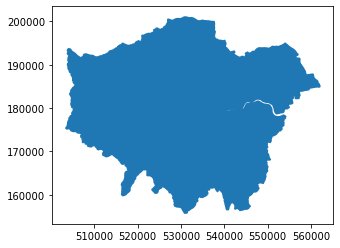

In [63]:
# Grab the Borough Boundaries
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# In order to ensure that we get all MSOAs _within_ London 
# we will buffer the boundary by 250m. If _cover_ were 
# easier to use then that option might be preferable.
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

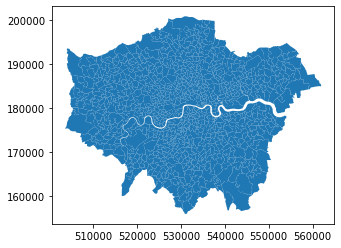

In [64]:
# Select London MSOAs using a Spatial Join
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

In [65]:
del(msoas)

In [66]:
# Extract Borough Names
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r' \d+$','',regex=True)

# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 14
print(ldn_msoas.Borough.unique())
print(len(ldn_msoas.Borough.unique()))
print(ldn_msoas.shape)

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
33
(983, 14)


In [67]:
# Add MSOA Names using a Merge
msoa_nms = pd.read_csv(ddir+'MSOA-Names-1.8.csv.gz', compression='gzip')

print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


msoa11cd        msoa11nm      msoa11nmw              msoa11hclnm  \
4512  E02005951      Oxford 012     Oxford 012  Grandpont & New Hinksey   
4660  W02000113       Powys 017      Powys 017                   Brecon   
1038  W02000309  Caerphilly 020  Caerffili 020       Bedwas & Trethomas   

            msoa11hclnmw      Laname  
4512                 NaN      Oxford  
4660          Aberhonddu       Powys  
1038  Bedwas a Thretomas  Caerphilly

In [68]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(983, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>


OBJECTID   MSOA11CD       MSOA11NM      msoa11hclnm
810       811  E02000841     Sutton 002  St Helier South
801       802  E02000832  Southwark 026    Nunhead North
813       814  E02000844     Sutton 005       The Wrythe

In [69]:
# Tidy up
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

# Save 
msoas.to_file('London_MSOAs.gpkg', driver='GPKG')

(983, 8)


In [70]:
# Add LA Names to Data
gdf_la = gpd.sjoin(com, boros, op='within', how='left')
print(gdf_la.columns.values)

print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

['id' 'listing_url' 'last_scraped' 'name' 'description' 'host_id'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_rate' 'host_acceptance_rate' 'host_is_superhost'
 'host_listings_count' 'host_total_listings_count' 'host_verifications'
 'latitude' 'longitude' 'property_type' 'room_type' 'accommodates'
 'bathrooms_text' 'bedrooms' 'beds' 'amenities' 'price' 'minimum_nights'
 'maximum_nights' 'availability_365' 'number_of_reviews' 'first_review'
 'last_review' 'review_scores_rating' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'instant_bookable'
 'calculated_host_listings_count' 'reviews_per_month' 'z' 'geometry'
 'description_norm' 'index_right' 'NAME' 'GSS_CODE' 'HECTARES'
 'NONLD_AREA' 'ONS_INNER']
(9795, 49)


id                                              name  \
331      357197  London, Hoxton. Nice, 2 bedroom, 7th floor flat.   
123      143478                Large room, London Fields, Hackney   
32817  26173350    Stunning Home in Perfect East London Location.   

                NAME  
331          Hackney  
123          Hackney  
32817  Tower Hamlets

In [71]:
# Tidy Up
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Islington', 'Hammersmith and Fulham', 'Haringey', 'Southwark',
       'Barnet', 'Lambeth', 'Hackney', 'Waltham Forest', 'Merton',
       'Croydon', 'Richmond upon Thames', 'Westminster', 'Camden',
       'Hounslow', 'Tower Hamlets', 'Greenwich', 'Lewisham', 'Newham',
       'Kensington and Chelsea', 'Brent', 'Ealing', 'Hillingdon',
       'Wandsworth', 'Enfield', 'Redbridge', 'Kingston upon Thames',
       'Bromley', 'City of London', 'Harrow', 'Havering', 'Sutton',
       'Barking and Dagenham', 'Bexley', nan], dtype=object)

In [93]:
gdf_la[gdf_la.NAME.isna()][['id','name']]

id                                  name
30638  24341533  Hampton Suites One Bedroom Apartment

<AxesSubplot:>

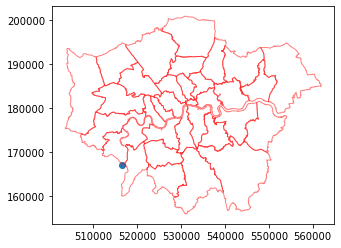

In [96]:
# Map Problematic Listings
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

In [97]:
# Drop Problematic Results
gdf_la.drop(index=gdf_la[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(9794, 45)


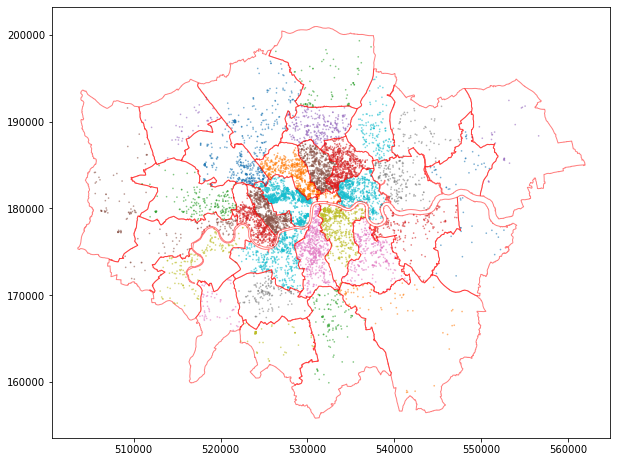

In [98]:
# Check Results
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

## Using Seaborn and Grouped Data

In [111]:
# Print all columns
gdf_la.columns

Index(['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'z', 'geometry',
       'description_norm', 'NAME', 'GSS_CODE'],
      dtype='object')

(0.0, 500.0)

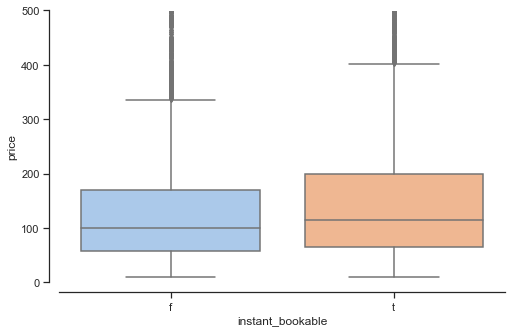

In [112]:
# Basic Boxplot
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(y=gdf_la.price, x=gdf_la.instant_bookable)
sns.despine(offset=10)
ax.set_ylim([0,500])

Text(0.5, 1.0, 'Pearson Correlation')

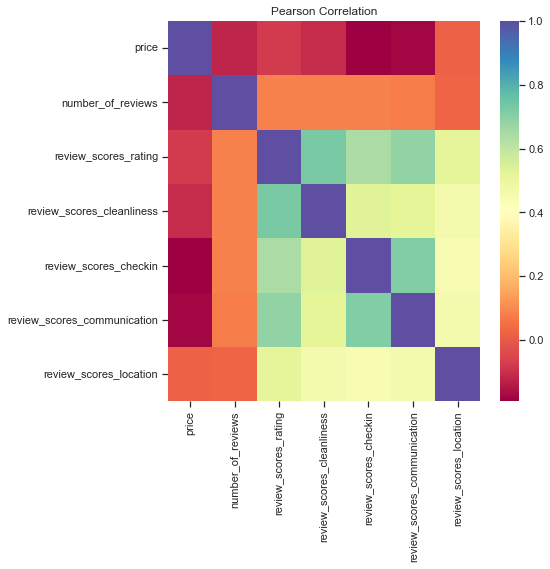

In [113]:
# Correlation check
variables = ['price','number_of_reviews','review_scores_rating','review_scores_cleanliness',
             'review_scores_checkin','review_scores_communication','review_scores_location']
corrmat = gdf_la[variables].corr()

# Heatmap
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.heatmap(corrmat, cmap='Spectral')
plt.title("Pearson Correlation")

# Experiment Codes

In [114]:
# # Grouping on One Column to see how prices are distributed over local authorities
# la_data = gdf_la.groupby(['NAME'])
# print(type(la_data))
# la_data.price.mean().sort_values(ascending=False)

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


NAME
Southwark                 486.502793
City of London            481.472727
Barnet                    395.441341
Westminster               389.738596
Islington                 248.016713
Kensington and Chelsea    239.124498
Camden                    208.497268
Hammersmith and Fulham    191.314225
Wandsworth                167.504255
Brent                     157.297030
Hackney                   150.851852
Hounslow                  143.904762
Richmond upon Thames      141.428571
Lambeth                   124.234589
Lewisham                  123.774074
Merton                    122.118519
Tower Hamlets             121.053824
Hillingdon                120.984848
Haringey                  116.977860
Ealing                    104.708108
Greenwich                 104.552795
Kingston upon Thames      104.433962
Newham                     90.911111
Bexley                     90.904762
Barking and Dagenham       83.636364
Havering                   80.666667
Waltham Forest             76.960

In [ ]:
# Exploring an LA using Subplots

In [115]:
# # Specifying the studied LA
# LA = 'Southwark' # With highest mean price for private 'Comfortable' rooms

# # Spatial Join Listings and MSOAs
# msoadf  = gpd.sjoin(
#             gdf_la[gdf_la.NAME==LA].reset_index(), 
#             msoas[msoas.Borough==LA], op='within')

In [117]:
# # Aggregate by MSOA
# msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()

# msoagrdf.columns = msoagrdf.columns.get_level_values(1)
# msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

# msoagrdf.head()

# # Join on Indexes
# msoa_gdf = msoagrdf.set_index('MSOA11NM').join(
#                 msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
#                 rsuffix='_r')s

# msoa_gdf.head(3)

median  listings  OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                               
Southwark 001    75.0         9       778  E02000807  535869  180025   
Southwark 002  1570.0       211       779  E02000808  532097  179964   
Southwark 003   146.0        34       780  E02000809  533540  179749   

                                                        geometry    Borough  \
MSOA11NM                                                                      
Southwark 001  POLYGON ((536516.404 180437.000, 536609.878 18...  Southwark   
Southwark 002  POLYGON ((532264.500 180540.100, 532329.562 18...  Southwark   
Southwark 003  POLYGON ((533994.396 179939.602, 533937.189 17...  Southwark   

                              msoa11hclnm  
MSOA11NM                                   
Southwark 001                 Rotherhithe  
Southwark 002  Borough & Southwark Street  
Southwark 003            Bermondsey North

In [ ]:
# # Create at Atlas-Type Output
# f,axes = plt.subplots(1,2,figsize=(12,8))

# msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
# msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
# for ax in axes:
#     ax.axis('off')
    
# ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
# boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
# boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
# ax2.axis('off')

# f.suptitle(LA, x=0.025, ha='left', size=24)
# axes[0].set_title('Median Price', size=20)
# axes[1].set_title('Listings', size=20)

# plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14);

# Executive Summary

This analysis aims to explore the influential factors on room prices that are listed on Airbnb. Previous work found Airbnb customers value more on characteristics of hosts, location, and amenities of rental places. This analysis will expand on their work, and gain more insights of Airbnb within London markets.

The adopted methodologies include statistical analysis, spatial analysis, textual analysis and correlation analysis. The findings indicate locations are important for room prices and pricey listings are concentrated around Hyde Park and Regent Park. Also, the private rooms emphasis more on comfortable rather than luxury. Moreover, based on findings in textual and correlation analysis, I recommend room providers who want to increase listed prices to offer guest access, shower room, private bathroom and more kindly services, However, the work is limited due to not taking the pandemic impact into accounts and the analysed granularity is too general to apply to a more specific area.

# Background

Airbnb is a popular platform for vacation rentals and there are various choices of room types for customers. Cheng and Jin (2019) found customers on Airbnb value more on experiences of communicating with hosts, rental location, and amenities when choosing a place to rent. Also, previous works found the location of Airbnb listings can greatly effect tourist's decision on renting a house (Eugenio-Martin *et al*, 2019; Gutiérrez *et al*, 2017).

This analysis aims to expand on others' work regarding to spatial pattern exploration and uncover factors that can influence listing prices within London. The results can be used for improving customer experiences and increasing profits of Airbnb hosts.

# Data Analysis

The studied dataset contains information about Airbnb listings data for London and is publicly published by Inside Airbnb (http://insideairbnb.com/get-the-data.html)http://insideairbnb.com/get-the-data.html) on 10th, October, 2021.

## Exploratory Analysis

There are 67903 listings in the studied dataset, and the mainstream room types are Entire home/apartment and private room, which accounts for 56% and 43%, respectively. The rest two types, shared room and hotel room, only accounts for 1% in total. The prices of listed rooms are ranged from \\$ 0 to \\$ 18012, however, I found rooms with prices less than 1 (exclusively) can be misguiding information. So, after excluded these invalid instances, the minim of listings' prices is \\$ 7. Figure 1.1 and 1.2 are the hex bin plots for the price distributions. It indicates the listing price could be correlated with location since the rooms with higher price are concentrated in the central area. Therefore, the next section will try to uncover the correlation between specific locations and room prices.

![Figure 1.1](images/download.png)
![Figure 1.2](images/download-1.png)

## Spatial Analysis

I combined the shape files of boroughs, water fields and green area in London with original dataset to gain more insights on location-related factors. Figure 2.1 to 2.3 illustrate that pricey rooms are more likely to be concentrated around Hyde Park, Regent Park and Victoria Park, which are very central and popular areas in London. While those inexpensive ones are distributed over the east of London.

![Figure 2.1](images/download-2.png)
![Figure 2.2](images/download-3.png)
![Figure 2.3](images/download-4.png)

The above plots provide more evidence indicating prices are correlated with listing locations. So far, obtained findings seem to be consistent with previous work discussed in the section of background. The next section will try to explore more features that have potential impacts on room price.

## Textual Analysis

On Airbnb, the host should give description on the published room. The description may contain information about the property type, location, guest access, amenities and so on. This section will take private rooms as an example, and extract some features from room descriptions to uncover the correlated variables with room prices.

I applied regular expressions to select rooms with descriptions implied characteristics of luxury and comfortable. The reason to choose these two key words is that I think customers on Airbnb will value these two aspects when they chose a room to rent.

For the luxury type of rooms, entire home and apartment and private room account for 77% and 22%, respectively. While for comfortable type of rooms, there are 10 percent increase in private room and decrease in entire room and apartment. The statistics indicate that private rooms may emphasise more on comfortable experiences rather than luxury ones. In addition, there are 36% of rooms described as comfortable among pricey category while 18% of rooms among inexpensive ones. This fact means rooms with higher price may provide more comfortable living environment.

Figure 3.1 to 3.4 display patterns found similar as previous findings. However, it seems that the price contribute more to distinctive distribution patterns rather than selected key words.

![Figure 3.1](images/download-5.png)
![Figure 3.2](images/download-6.png)
![Figure 3.3](images/download-7.png)
![Figure 3.4](images/download-8.png)

Then, I used term frequency–inverse document frequency (tf-idf) technique to discover the most frequent words that are used to describe a room. Taking rooms that are described as comfortable as an example, the competitive points of pricey rooms are **guest access**, **shower room** and **private bathroom**. While the inexpensive rooms seem to own many similar properties, such as double bed and nice location. Table 3.5 displays the top 10 keys words (in order) appeared in descriptions among two categories. According word clouds are displayed in Figure 3.6 and 3.7.

![Figure 3.6](images/download-9.png)
![Figure 3.7](images/download-11.png)

Table 3.5 Keywords found in descriptions for private rooms

| Pricey | Inexpensive |
| --- | --- |
| guest access <br/>minute walk <br/>central london<br/>living room <br/>double bed<br/>thing note <br/>room comfortable <br/>private bathroom <br/>shower room <br/>double bedroom | central london <br/>minute walk <br/>thing note <br/>double room <br/>double bed <br/>living room <br/>min walk <br/>double bedroom <br/>kitchen bathroom <br/>tube station |

## Correlation Analysis

At the end, I adopted correlation analysis to quantitatively explore the correlation between existing variables and room prices. Figure 4.1 displays the Pearson correlations between price and selected variables. The heat-map doesn't show a significant pattern but the review scores of communication and check-in experiences seem to negatively contribute to room price.

![Figure 4.1](images/download-12.png)

# Conclusion

In conclusion, this analysis aims to explore the factors that may impact on listed room prices on Airbnb. The studied data are available publicly and collected on 10th, October 2021. I performed four types of analysis including exploratory analysis, spatial analysis, textual analysis and correlation analysis. The obtained findings implicit that

1. Room prices are unevenly distributed over spatial space. Rooms with higher prices are concentrated in central London, while those with lower prices are distributed surrounding the central area;
  
2. Combining the map illustrating water and green fields, I found the pricey rooms are centred around Hyde Park and Regent Park, while the inexpensive ones are distributed over east of London;
  
3. Taking private rooms as an example, they emphasise more on comfortable experiences rather than luxury ones. Also, I found rooms with higher price may provide more comfortable living environment. Moreover, locations may contribute more to room price than comfortable experiences;
  
4. For comfortable private rooms, pricey ones may be valued more on guest access, shower room, and private bathroom than inexpensive ones;
  
5. The Pearson correlation analysis showed no significant pattern between room prices and review scores. But it implicit scores regarding communication and check-in experiences have negative impact on room price. This fact means the inexpensive rooms may provide more friendly services.
  

## Limitations

This section will discuss the limitations of this analysis.

1. The studied dataset covered a period of pandemic outbreak, which has a great impact on tourism industry (Gyódi, 2021; Bresciani *et al*, 2021). However, I haven't taken this fact as an influential factor in the analysis.
  
2. The figures and analysis are based on a general granularity over spatial space, which may bring troubles when apply the result to a more specific area.
  

## Recommendations

Based on the obtained findings, I recommend the providers who want to increase the room price to provide tenants a more comfortable living environment. To achieve this, providers can offer guest access, shower room, and private bathroom. Also, they should be kind to Airbnb users to gain higher review scores.

# Bibliography

[Bresciani, S., Ferraris, A., Santoro, G., Premazzi, K., Quaglia, R., Yahiaoui, D., & Viglia, G.. (2021). The seven lives of Airbnb. The role of accommodation types. *Annals of Tourism Research*, *88*, 103170. ](https://doi.org/10.1016/j.annals.2021.103170)

[Cheng, M., & Jin, X.. (2019). What do Airbnb users care about? An analysis of online review comments. *International Journal of Hospitality Management*, *76*, 58–70.](https://doi.org/10.1016/j.ijhm.2018.04.004)

[Eugenio-Martin, J. L., Cazorla-Artiles, J. M., & González-Martel, C.. (2019). On the determinants of Airbnb location and its spatial distribution. *Tourism Economics*, *25*(8), 1224–1244. ](https://doi.org/10.1177/1354816618825415)

[Gutiérrez, J., García-Palomares, J. C., Romanillos, G., & Salas-Olmedo, M. H.. (2017). The eruption of Airbnb in tourist cities: Comparing spatial patterns of hotels and peer-to-peer accommodation in Barcelona. *Tourism Management*, *62*, 278–291.](https://doi.org/10.1016/j.tourman.2017.05.003)

[Gyódi, K.. (2021). Airbnb and hotels during COVID-19: different strategies to survive. *International Journal of Culture, Tourism and Hospitality Research*, *ahead-of-print*(ahead-of-print).](https://doi.org/10.1108/ijcthr-09-2020-0221)